In [14]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
import time
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

In [15]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left[-\frac{1}{\xi_a}(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y)\left(z_2 e-y\rho(z_2-\mu_2)+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{1}{2}\frac{d^2}{d\tau^2}\Lambda_j(z_2y)z_2y^2|\sigma_2|^2\right)\right]\pi_j^o
$$

FOC of $h_2$ gives : 

\begin{align}
h_2^* = -\frac{\frac{\partial \phi}{\partial z_2}(y, z_2)\sqrt{z_2}\sigma_2 + (\eta-1)\sum_{j}^J \pi_j \frac{d}{d \tau}\Lambda_j(z_2 y)\left(y\sqrt{z_2}\sigma_2\right)}{\xi_m}
\end{align}

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2) + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(z_2 y)z_2}
$$

In [163]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat*z_mat + 
                            λ_2p_j*(y_mat*z_mat>λ_bar)*(y_mat*z_mat-λ_bar) for λ_2p_j in λ_2p])
    dd_Λ = np.array([λ_2 + λ_2p_j*(y_mat*z_mat>λ_bar) for λ_2p_j in λ_2p])
    d_Λ_yz_sigma = d_Λ*y_mat*np.sqrt(z_mat)*σ_2
    d_Λ_z = d_Λ*z_mat
    mean_reversion = - y_mat*ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    std_y = y_mat*std
    variance = z_mat*y_mat**2*σ_2**2

    π = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
    π_o = π.copy()
    h = - (η-1.) / ξ_m * np.sum(π*d_Λ_yz_sigma, axis=0)
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        temp = d_Λ*(z_mat*e + mean_reversion + std_y*h) + 0.5*dd_Λ*variance
        log_π_ratio = -(η-1.)*temp/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12
        
        h = - (v0_dz*std + (η-1)*np.sum(π*d_Λ_yz_sigma, axis=0)) / ξ_m
        e = - δ*η / (v0_dy + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e[e<=0] = 1e-12

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*np.sum(π*temp, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, h, π

In [184]:
# Model parameters
η = .032
# ξ_m = .00256
# ξ_m = .05
ξ_m = 1000
ξ_a = .1
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
# λ_2p = np.array([0., 0.0197*2, 0.3853*2])
# π_o = np.array([0.475, 0.475, 0.05])

# two damage
λ_2p = np.array([0., 0.0197*2])
π_o = np.array([0.5, 0.5])

pde_paras = (η, ξ_m, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 2000.
y_grid = np.linspace(y_min, y_max, n_y)

In [183]:
ϕ_grid, e_grid, h_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.04993029435141061; RHS Error 0.0725345638950519
Iteration 2: LHS Error: 0.03497200049663074; RHS Error 0.04986843209313045
Iteration 3: LHS Error: 0.025015049126859035; RHS Error 0.03484617455597124
Iteration 4: LHS Error: 0.018419021225589916; RHS Error 0.024922230084947886
Iteration 5: LHS Error: 0.014028298797285732; RHS Error 0.018348250245392286
Iteration 6: LHS Error: 0.01108869730581552; RHS Error 0.013972352643728092
Iteration 7: LHS Error: 0.00910856565994056; RHS Error 0.011042773471906374
Iteration 8: LHS Error: 0.007766342741321042; RHS Error 0.009069454560520267
Iteration 9: LHS Error: 0.006850573699787255; RHS Error 0.007731889566528274
Iteration 10: LHS Error: 0.0062213419704451045; RHS Error 0.00681932521273608
Iteration 11: LHS Error: 0.005785498253509491; RHS Error 0.006192315080536082
Iteration 12: LHS Error: 0.005480674381096451; RHS Error 0.00575802564299014
Iteration 13: LHS Error: 0.005264899926221922; RHS Error 0.005454301957583653
Iter

Iteration 107: LHS Error: 0.0030466892371119325; RHS Error 0.003046542510272518
Iteration 108: LHS Error: 0.0030316771833477363; RHS Error 0.003031531136478527
Iteration 109: LHS Error: 0.0030167391472006866; RHS Error 0.003016593776900056
Iteration 110: LHS Error: 0.003001874762833756; RHS Error 0.0030017300670895503
Iteration 111: LHS Error: 0.0029870839183047115; RHS Error 0.0029869396431310147
Iteration 112: LHS Error: 0.0029723656458620074; RHS Error 0.0029722223054477193
Iteration 113: LHS Error: 0.0029577199885356675; RHS Error 0.0029575772644885867
Iteration 114: LHS Error: 0.0029431465673854795; RHS Error 0.0029430044746870526
Iteration 115: LHS Error: 0.0029286450083824134; RHS Error 0.0029285035609770693
Iteration 116: LHS Error: 0.002914214953128158; RHS Error 0.0029140741538407067
Iteration 117: LHS Error: 0.002899855742130586; RHS Error 0.002899715896769975
Iteration 118: LHS Error: 0.002885568071178679; RHS Error 0.0028854282391533176
Iteration 119: LHS Error: 0.00287135

Iteration 211: LHS Error: 0.0018228743597267227; RHS Error 0.0018227846170428552
Iteration 212: LHS Error: 0.0018138945673068507; RHS Error 0.0018138052627994644
Iteration 213: LHS Error: 0.0018049590271003169; RHS Error 0.0018048701671292133
Iteration 214: LHS Error: 0.001796067519918787; RHS Error 0.0017959791013285042
Iteration 215: LHS Error: 0.001787219827467712; RHS Error 0.0017871318518049434
Iteration 216: LHS Error: 0.0017784157323094685; RHS Error 0.0017783281933119038
Iteration 217: LHS Error: 0.001769655019936145; RHS Error 0.00176956792590853
Iteration 218: LHS Error: 0.0017609374755072071; RHS Error 0.0017608508211768709
Iteration 219: LHS Error: 0.0017522628863400613; RHS Error 0.0017521766721639714
Iteration 220: LHS Error: 0.0017436310411498845; RHS Error 0.0017435452647639738
Iteration 221: LHS Error: 0.0017350417280710961; RHS Error 0.001734956388250955
Iteration 222: LHS Error: 0.001726494737729567; RHS Error 0.001726409836946538
Iteration 223: LHS Error: 0.00171798

Iteration 313: LHS Error: 0.0011015624351511932; RHS Error 0.0011015108906119314
Iteration 314: LHS Error: 0.0010961364089400738; RHS Error 0.0010960851812132216
Iteration 315: LHS Error: 0.0010907371115551623; RHS Error 0.0010906862026394543
Iteration 316: LHS Error: 0.0010853644114500738; RHS Error 0.0010853138187851968
Iteration 317: LHS Error: 0.0010800181768292894; RHS Error 0.001079967900309356
Iteration 318: LHS Error: 0.0010746982785228565; RHS Error 0.001074648315011098
Iteration 319: LHS Error: 0.001069404585415934; RHS Error 0.00106935493744377
Iteration 320: LHS Error: 0.0010641369686051894; RHS Error 0.0010640876336879268
Iteration 321: LHS Error: 0.0010588953001003931; RHS Error 0.0010588462762992634
Iteration 322: LHS Error: 0.0010536794521709414; RHS Error 0.0010536307387339072
Iteration 323: LHS Error: 0.00104848929668655; RHS Error 0.0010484408935656497
Iteration 324: LHS Error: 0.0010433247080180452; RHS Error 0.0010432766143717437
Iteration 325: LHS Error: 0.0010381

Iteration 415: LHS Error: 0.0006657127906916638; RHS Error 0.0006666008633943142
Iteration 416: LHS Error: 0.0006624210008347731; RHS Error 0.0006633376167128301
Iteration 417: LHS Error: 0.0006591514851470026; RHS Error 0.0006600899070332671
Iteration 418: LHS Error: 0.0006559008438822844; RHS Error 0.0006568584825981036
Iteration 419: LHS Error: 0.0006526683564536395; RHS Error 0.0006536431490615675
Iteration 420: LHS Error: 0.000649452923385252; RHS Error 0.0006504436501152053
Iteration 421: LHS Error: 0.0006462532142690602; RHS Error 0.000647259899489841
Iteration 422: LHS Error: 0.0006430695397527386; RHS Error 0.0006440918802769688
Iteration 423: LHS Error: 0.0006399016922149781; RHS Error 0.000640939458589649
Iteration 424: LHS Error: 0.0006367495311717375; RHS Error 0.0006378025535876096
Iteration 425: LHS Error: 0.0006336129430356829; RHS Error 0.0006346810896694886
Iteration 426: LHS Error: 0.0006304918315104269; RHS Error 0.0006315749918759592
Iteration 427: LHS Error: 0.000

Iteration 517: LHS Error: 0.00040227262360686966; RHS Error 0.0004047437736936395
Iteration 518: LHS Error: 0.0004002909968726931; RHS Error 0.00040278055115951575
Iteration 519: LHS Error: 0.00039831950601706967; RHS Error 0.00040082699671351724
Iteration 520: LHS Error: 0.00039635720824213183; RHS Error 0.00039888307397008965
Iteration 521: LHS Error: 0.0003944042300438322; RHS Error 0.0003969487246149317
Iteration 522: LHS Error: 0.00039246181439883676; RHS Error 0.00039502389011743244
Iteration 523: LHS Error: 0.000390528022658182; RHS Error 0.0003931085380949953
Iteration 524: LHS Error: 0.00038860430225748366; RHS Error 0.00039120259982398584
Iteration 525: LHS Error: 0.00038669043407144055; RHS Error 0.00038930604600118796
Iteration 526: LHS Error: 0.00038478503142622134; RHS Error 0.0003874188368729846
Iteration 527: LHS Error: 0.0003828899927474927; RHS Error 0.0003855409125210346
Iteration 528: LHS Error: 0.00038100331401361154; RHS Error 0.0003836722471998767
Iteration 529: 

Iteration 617: LHS Error: 0.00024549536687007434; RHS Error 0.0002497569515058917
Iteration 618: LHS Error: 0.0002442859096050132; RHS Error 0.0002485638574383983
Iteration 619: LHS Error: 0.00024308241043466405; RHS Error 0.00024737663737707527
Iteration 620: LHS Error: 0.0002418848380034977; RHS Error 0.00024619526080332105
Iteration 621: LHS Error: 0.00024069314053845603; RHS Error 0.0002450196985331367
Iteration 622: LHS Error: 0.00023950737140920886; RHS Error 0.00024384992313073242
Iteration 623: LHS Error: 0.000238327406384492; RHS Error 0.00024268590627835387
Iteration 624: LHS Error: 0.00023715325397891118; RHS Error 0.00024152761949500223
Iteration 625: LHS Error: 0.000235984857616528; RHS Error 0.00024037503309900718
Iteration 626: LHS Error: 0.0002348222827443791; RHS Error 0.00023922812131287746
Iteration 627: LHS Error: 0.00023366539450628276; RHS Error 0.0002380868558743282
Iteration 628: LHS Error: 0.0002325141753130866; RHS Error 0.00023695120548583234
Iteration 629: L

Iteration 717: LHS Error: 0.0001498109047828322; RHS Error 0.0002010215230353156
Iteration 718: LHS Error: 0.00014907273772396534; RHS Error 0.00020175958327507681
Iteration 719: LHS Error: 0.000148338232340256; RHS Error 0.00020249407479935866
Iteration 720: LHS Error: 0.0001476073527135191; RHS Error 0.0002032249120952033
Iteration 721: LHS Error: 0.000146880063297411; RHS Error 0.00020395214445737345
Iteration 722: LHS Error: 0.00014615636456571934; RHS Error 0.00020467580764347085
Iteration 723: LHS Error: 0.0001454362218892835; RHS Error 0.00020539589622354387
Iteration 724: LHS Error: 0.000144719634379592; RHS Error 0.00020611244937578793
Iteration 725: LHS Error: 0.00014400656911858767; RHS Error 0.0002068254620752781
Iteration 726: LHS Error: 0.00014329702052309767; RHS Error 0.0002075349728012446
Iteration 727: LHS Error: 0.0001425909731451458; RHS Error 0.000208240981407877
Iteration 728: LHS Error: 0.00014188839337508918; RHS Error 0.00020894350658828137
Iteration 729: LHS E

Iteration 817: LHS Error: 9.141503475641743e-05; RHS Error 0.0002594139146170904
Iteration 818: LHS Error: 9.096458655295792e-05; RHS Error 0.00025986421414206026
Iteration 819: LHS Error: 9.051628151252045e-05; RHS Error 0.0002603123807670693
Iteration 820: LHS Error: 9.007033577862478e-05; RHS Error 0.00026075842039917363
Iteration 821: LHS Error: 8.962648249337402e-05; RHS Error 0.0002612021623435469
Iteration 822: LHS Error: 8.918475499306022e-05; RHS Error 0.0002616438127371716
Iteration 823: LHS Error: 8.874535851256804e-05; RHS Error 0.0002620833188012456
Iteration 824: LHS Error: 8.830802898891765e-05; RHS Error 0.00026252054491530605
Iteration 825: LHS Error: 8.787279464196607e-05; RHS Error 0.00026295570099345994
Iteration 826: LHS Error: 8.743987121062613e-05; RHS Error 0.00026338874491601064
Iteration 827: LHS Error: 8.700895658476926e-05; RHS Error 0.00026381952848180193
Iteration 828: LHS Error: 8.658012323527198e-05; RHS Error 0.0002642483024762679
Iteration 829: LHS Err

Iteration 918: LHS Error: 5.550345657048816e-05; RHS Error 0.00029532313502957097
Iteration 919: LHS Error: 5.522991491010987e-05; RHS Error 0.00029559666162571815
Iteration 920: LHS Error: 5.49577193830475e-05; RHS Error 0.0002958688391391136
Iteration 921: LHS Error: 5.4686864936787094e-05; RHS Error 0.00029613967726612594
Iteration 922: LHS Error: 5.441733950538319e-05; RHS Error 0.0002964091801515266
Iteration 923: LHS Error: 5.414915209864257e-05; RHS Error 0.0002966773573254075
Iteration 924: LHS Error: 5.3882284389253354e-05; RHS Error 0.0002969442083201601
Iteration 925: LHS Error: 5.3616727771030326e-05; RHS Error 0.0002972097468831557
Iteration 926: LHS Error: 5.3352482738702744e-05; RHS Error 0.0002974739779519099
Iteration 927: LHS Error: 5.3089538222833577e-05; RHS Error 0.00029773690530019575
Iteration 928: LHS Error: 5.2827888456633e-05; RHS Error 0.00029799853977563115
Iteration 929: LHS Error: 5.256753201494935e-05; RHS Error 0.0002982588829074026
Iteration 930: LHS Er

Iteration 1019: LHS Error: 3.369689020174538e-05; RHS Error 0.0003171285528671304
Iteration 1020: LHS Error: 3.353079425116867e-05; RHS Error 0.0003172946398892311
Iteration 1021: LHS Error: 3.336551622595829e-05; RHS Error 0.00031745990624265294
Iteration 1022: LHS Error: 3.320105186131739e-05; RHS Error 0.00031762435945158554
Iteration 1023: LHS Error: 3.3037400969965214e-05; RHS Error 0.00031778799934231716
Iteration 1024: LHS Error: 3.287455342300405e-05; RHS Error 0.000317950836918119
Iteration 1025: LHS Error: 3.27125111658777e-05; RHS Error 0.00031811286953505394
Iteration 1026: LHS Error: 3.255126591653057e-05; RHS Error 0.0003182741053857491
Iteration 1027: LHS Error: 3.2390815211627566e-05; RHS Error 0.000318434545543405
Iteration 1028: LHS Error: 3.223115426893852e-05; RHS Error 0.0003185941944892426
Iteration 1029: LHS Error: 3.2072282440009925e-05; RHS Error 0.00031875305591593656
Iteration 1030: LHS Error: 3.191419202736023e-05; RHS Error 0.00031891113862598727
Iteration 

Iteration 1118: LHS Error: 2.0659783267359955e-05; RHS Error 0.0003301648246148217
Iteration 1119: LHS Error: 2.0557938780280116e-05; RHS Error 0.00033026666428436977
Iteration 1120: LHS Error: 2.0456594126375127e-05; RHS Error 0.00033036800095122623
Iteration 1121: LHS Error: 2.035575057772465e-05; RHS Error 0.0003304688394591346
Iteration 1122: LHS Error: 2.0255403275284967e-05; RHS Error 0.00033056918079304304
Iteration 1123: LHS Error: 2.0155548679193225e-05; RHS Error 0.00033066902687411623
Iteration 1124: LHS Error: 2.005619041790807e-05; RHS Error 0.0003307683806442023
Iteration 1125: LHS Error: 1.995731913523313e-05; RHS Error 0.0003308672463292889
Iteration 1126: LHS Error: 1.98589359152318e-05; RHS Error 0.0003309656226441922
Iteration 1127: LHS Error: 1.976103658420103e-05; RHS Error 0.00033106351518958493
Iteration 1128: LHS Error: 1.9663619799922816e-05; RHS Error 0.0003311609253569166
Iteration 1129: LHS Error: 1.9566684019034497e-05; RHS Error 0.0003312578560285967
Itera

Iteration 1218: LHS Error: 1.2603594842286459e-05; RHS Error 0.0003382204440809562
Iteration 1219: LHS Error: 1.2541769544349712e-05; RHS Error 0.0003382825610917621
Iteration 1220: LHS Error: 1.2479607693627326e-05; RHS Error 0.00033834442158225606
Iteration 1221: LHS Error: 1.241809339824762e-05; RHS Error 0.00033840593187947285
Iteration 1222: LHS Error: 1.2356917482095331e-05; RHS Error 0.00033846713452917107
Iteration 1223: LHS Error: 1.2296276872145184e-05; RHS Error 0.0003385280499999671
Iteration 1224: LHS Error: 1.2235314010261567e-05; RHS Error 0.00033858870316790315
Iteration 1225: LHS Error: 1.2175005319289833e-05; RHS Error 0.0003386490111102654
Iteration 1226: LHS Error: 1.2115025625536457e-05; RHS Error 0.0003387090155637165
Iteration 1227: LHS Error: 1.205531450011732e-05; RHS Error 0.00033876873803544497
Iteration 1228: LHS Error: 1.1995886907770203e-05; RHS Error 0.00033882817091664824
Iteration 1229: LHS Error: 1.1936747786170376e-05; RHS Error 0.0003388873107172119


Iteration 1319: LHS Error: 7.650542593273801e-06; RHS Error 0.00034317323729065805
Iteration 1320: LHS Error: 7.612825663680378e-06; RHS Error 0.00034321096131769216
Iteration 1321: LHS Error: 7.57528968914345e-06; RHS Error 0.0003432484987403832
Iteration 1322: LHS Error: 7.537938934182309e-06; RHS Error 0.0003432858480430061
Iteration 1323: LHS Error: 7.500771712937171e-06; RHS Error 0.0003433230144239338
Iteration 1324: LHS Error: 7.463786055095234e-06; RHS Error 0.0003433599974770711
Iteration 1325: LHS Error: 7.4270319696534415e-06; RHS Error 0.0003433967978153027
Iteration 1326: LHS Error: 7.3903277209436125e-06; RHS Error 0.00034343344208967105
Iteration 1327: LHS Error: 7.353913347260543e-06; RHS Error 0.00034346983470779496
Iteration 1328: LHS Error: 7.317658694841467e-06; RHS Error 0.00034350611177797613
Iteration 1329: LHS Error: 7.281577803011641e-06; RHS Error 0.0003435421931133123
Iteration 1330: LHS Error: 7.245673767336536e-06; RHS Error 0.0003435780953775572
Iteration 

Iteration 1420: LHS Error: 4.643715044258534e-06; RHS Error 0.000346179902770076
Iteration 1421: LHS Error: 4.620815148778656e-06; RHS Error 0.00034620280128870584
Iteration 1422: LHS Error: 4.598027883120914e-06; RHS Error 0.0003462255868583834
Iteration 1423: LHS Error: 4.575352755803452e-06; RHS Error 0.00034624825946344764
Iteration 1424: LHS Error: 4.552790611997426e-06; RHS Error 0.00034627082092062583
Iteration 1425: LHS Error: 4.5303388387374355e-06; RHS Error 0.0003462932714019089
Iteration 1426: LHS Error: 4.507997427211086e-06; RHS Error 0.0003463156110596298
Iteration 1427: LHS Error: 4.485767383086148e-06; RHS Error 0.0003463378399054355
Iteration 1428: LHS Error: 4.463645350186174e-06; RHS Error 0.00034635995987093715
Iteration 1429: LHS Error: 4.441634140414652e-06; RHS Error 0.0003463819705325846
Iteration 1430: LHS Error: 4.419730381399756e-06; RHS Error 0.00034640387280659643
Iteration 1431: LHS Error: 4.397934052852159e-06; RHS Error 0.00034642566667104566
Iteration 

Iteration 1520: LHS Error: 2.8319389339115375e-06; RHS Error 0.00034799130376836004
Iteration 1521: LHS Error: 2.818324088924018e-06; RHS Error 0.00034800554249810045
Iteration 1522: LHS Error: 2.8040920530408853e-06; RHS Error 0.0003480191927626025
Iteration 1523: LHS Error: 2.7902641718813292e-06; RHS Error 0.0003480332848950149
Iteration 1524: LHS Error: 2.7768902075425705e-06; RHS Error 0.0003480470225386001
Iteration 1525: LHS Error: 2.76281940542189e-06; RHS Error 0.00034806049115698734
Iteration 1526: LHS Error: 2.7495428432111613e-06; RHS Error 0.00034807438051363826
Iteration 1527: LHS Error: 2.735924728297645e-06; RHS Error 0.00034808769263789535
Iteration 1528: LHS Error: 2.722396634416424e-06; RHS Error 0.00034810121777710534
Iteration 1529: LHS Error: 2.708953592403529e-06; RHS Error 0.00034811465309176823
Iteration 1530: LHS Error: 2.6953461756407116e-06; RHS Error 0.00034812801514635255
Iteration 1531: LHS Error: 2.6820309691061306e-06; RHS Error 0.0003481415261461229
It

Iteration 1620: LHS Error: 1.7270884534736908e-06; RHS Error 0.000349096383296138
Iteration 1621: LHS Error: 1.7185688082482775e-06; RHS Error 0.0003491049013302147
Iteration 1622: LHS Error: 1.7100916016032919e-06; RHS Error 0.0003491133780058435
Iteration 1623: LHS Error: 1.7016558182814112e-06; RHS Error 0.000349121811659938
Iteration 1624: LHS Error: 1.6932617118714521e-06; RHS Error 0.00034913020639267336
Iteration 1625: LHS Error: 1.6849091403203786e-06; RHS Error 0.00034913855822862536
Iteration 1626: LHS Error: 1.6765977669391807e-06; RHS Error 0.0003491468686872973
Iteration 1627: LHS Error: 1.668327408166359e-06; RHS Error 0.0003491551383074179
Iteration 1628: LHS Error: 1.6600978559738744e-06; RHS Error 0.0003491633670912042
Iteration 1629: LHS Error: 1.6519089112709828e-06; RHS Error 0.0003491715554563464
Iteration 1630: LHS Error: 1.6437603653635113e-06; RHS Error 0.00034917970317345504
Iteration 1631: LHS Error: 1.6356520440991007e-06; RHS Error 0.0003491878108311322
Iter

Iteration 1720: LHS Error: 1.0532050917083646e-06; RHS Error 0.00034977018903407237
Iteration 1721: LHS Error: 1.0480100390841685e-06; RHS Error 0.00034977538436864464
Iteration 1722: LHS Error: 1.0428406516244104e-06; RHS Error 0.00034978055404509545
Iteration 1723: LHS Error: 1.0376967367470291e-06; RHS Error 0.00034978569754522126
Iteration 1724: LHS Error: 1.0325781656661537e-06; RHS Error 0.00034979081574279536
Iteration 1725: LHS Error: 1.0274848467883846e-06; RHS Error 0.0003497959086345252
Iteration 1726: LHS Error: 1.0224166729355666e-06; RHS Error 0.0003498009768623696
Iteration 1727: LHS Error: 1.0173734863588857e-06; RHS Error 0.00034980601962689845
Iteration 1728: LHS Error: 1.0123552071222841e-06; RHS Error 0.000349811037506538
Iteration 1729: LHS Error: 1.0073616557859655e-06; RHS Error 0.0003498160309522297
Iteration 1730: LHS Error: 1.0023927751318107e-06; RHS Error 0.00034982099983733514
Iteration 1731: LHS Error: 9.974483938801626e-07; RHS Error 0.0003498259431886641

Iteration 1820: LHS Error: 6.423740900873831e-07; RHS Error 0.00035018099198747335
Iteration 1821: LHS Error: 6.392063508914303e-07; RHS Error 0.0003501841599042807
Iteration 1822: LHS Error: 6.360543563510568e-07; RHS Error 0.00035018731133312775
Iteration 1823: LHS Error: 6.329176540087467e-07; RHS Error 0.00035019044669423044
Iteration 1824: LHS Error: 6.297966117091436e-07; RHS Error 0.00035019356911916016
Iteration 1825: LHS Error: 6.266907216223583e-07; RHS Error 0.00035019667346544714
Iteration 1826: LHS Error: 6.236004851251087e-07; RHS Error 0.0003501997646224303
Iteration 1827: LHS Error: 6.205252749275081e-07; RHS Error 0.00035020283842233935
Iteration 1828: LHS Error: 6.1746524188111e-07; RHS Error 0.00035020589918008035
Iteration 1829: LHS Error: 6.14420455263831e-07; RHS Error 0.00035020894397438593
Iteration 1830: LHS Error: 6.113906200477803e-07; RHS Error 0.0003502119733817845
Iteration 1831: LHS Error: 6.083758023744945e-07; RHS Error 0.0003502149879440336
Iteration 1

Iteration 1920: LHS Error: 3.917459848595817e-07; RHS Error 0.0003504315952204129
Iteration 1921: LHS Error: 3.8981455414976995e-07; RHS Error 0.0003504335262221013
Iteration 1922: LHS Error: 3.8789252083948345e-07; RHS Error 0.00035043544817156547
Iteration 1923: LHS Error: 3.8597994671263347e-07; RHS Error 0.0003504373609619395
Iteration 1924: LHS Error: 3.8407698857434447e-07; RHS Error 0.0003504392635851998
Iteration 1925: LHS Error: 3.8218325973393696e-07; RHS Error 0.00035044115758457034
Iteration 1926: LHS Error: 3.802989087947628e-07; RHS Error 0.00035044304150811875
Iteration 1927: LHS Error: 3.7842396423404256e-07; RHS Error 0.0003504449163988059
Iteration 1928: LHS Error: 3.765581481490754e-07; RHS Error 0.00035044678266790696
Iteration 1929: LHS Error: 3.747015199645487e-07; RHS Error 0.00035044863875288365
Iteration 1930: LHS Error: 3.72854232294495e-07; RHS Error 0.0003504504855877978
Iteration 1931: LHS Error: 3.7101593652888454e-07; RHS Error 0.0003504523241728147
Itera

Iteration 2019: LHS Error: 2.4156859827761945e-07; RHS Error 0.0003505831295020703
Iteration 2020: LHS Error: 2.5221391233842816e-07; RHS Error 0.0003505843637233094
Iteration 2021: LHS Error: 2.3799015515246769e-07; RHS Error 0.00035058549456098986
Iteration 2022: LHS Error: 2.3668165544110664e-07; RHS Error 0.0003505866503600054
Iteration 2023: LHS Error: 2.3551148103928554e-07; RHS Error 0.00035058780379046417
Iteration 2024: LHS Error: 2.3433397927652422e-07; RHS Error 0.00035058896769470105
Iteration 2025: LHS Error: 2.3316826203156893e-07; RHS Error 0.0003505901386787469
Iteration 2026: LHS Error: 2.3201002802286652e-07; RHS Error 0.00035059129985341025
Iteration 2027: LHS Error: 2.3085615064033504e-07; RHS Error 0.0003505924522667035
Iteration 2028: LHS Error: 2.2970932805899125e-07; RHS Error 0.00035059359986600036
Iteration 2029: LHS Error: 2.2858578384299388e-07; RHS Error 0.0003505947410509559
Iteration 2030: LHS Error: 2.2746904382309197e-07; RHS Error 0.0003505958747048870

Iteration 2119: LHS Error: 1.4659750778578395e-07; RHS Error 0.0003506767661756033
Iteration 2120: LHS Error: 1.4587532880250276e-07; RHS Error 0.00035067748765132273
Iteration 2121: LHS Error: 1.4515793018976542e-07; RHS Error 0.00035067820630116375
Iteration 2122: LHS Error: 1.4444112682310273e-07; RHS Error 0.000350678921486134
Iteration 2123: LHS Error: 1.437300739676184e-07; RHS Error 0.00035067963264036675
Iteration 2124: LHS Error: 1.430224606385755e-07; RHS Error 0.0003506803395042536
Iteration 2125: LHS Error: 1.4231850578583227e-07; RHS Error 0.0003506810440347362
Iteration 2126: LHS Error: 1.4161700771786467e-07; RHS Error 0.0003506817451122933
Iteration 2127: LHS Error: 1.409198595730965e-07; RHS Error 0.0003506824424210665
Iteration 2128: LHS Error: 1.402260214888873e-07; RHS Error 0.0003506831354574344
Iteration 2129: LHS Error: 1.3953536093236352e-07; RHS Error 0.00035068382576973825
Iteration 2130: LHS Error: 1.388480069253184e-07; RHS Error 0.00035068451300159995
Itera

Iteration 2218: LHS Error: 9.010280807575377e-08; RHS Error 0.0003507332814317622
Iteration 2219: LHS Error: 8.965864668752932e-08; RHS Error 0.00035073371034980566
Iteration 2220: LHS Error: 8.921419664131847e-08; RHS Error 0.00035073414967773386
Iteration 2221: LHS Error: 8.899118070226919e-08; RHS Error 0.0003507345784215868
Iteration 2222: LHS Error: 8.838146936529512e-08; RHS Error 0.00035073482138473985
Iteration 2223: LHS Error: 8.793667628792523e-08; RHS Error 0.0003507355587906956
Iteration 2224: LHS Error: 8.765466102955699e-08; RHS Error 0.0003507359036198192
Iteration 2225: LHS Error: 8.709946354434894e-08; RHS Error 0.00035073614285941607
Iteration 2226: LHS Error: 8.677129470502365e-08; RHS Error 0.0003507368412322201
Iteration 2227: LHS Error: 8.625719108423802e-08; RHS Error 0.00035073701873026067
Iteration 2228: LHS Error: 8.592155570363857e-08; RHS Error 0.00035073768728816415
Iteration 2229: LHS Error: 8.540426071901308e-08; RHS Error 0.0003507378635930966
Iteration 

Iteration 2320: LHS Error: 5.456115934054928e-08; RHS Error 0.0003507687929969021
Iteration 2321: LHS Error: 5.429280376667567e-08; RHS Error 0.0003507690610382412
Iteration 2322: LHS Error: 5.402550706801179e-08; RHS Error 0.0003507693283931468
Iteration 2323: LHS Error: 5.3837959479441366e-08; RHS Error 0.00035076959252313897
Iteration 2324: LHS Error: 5.351612261672578e-08; RHS Error 0.00035076977892425226
Iteration 2325: LHS Error: 5.3237438984998775e-08; RHS Error 0.00035077017017241113
Iteration 2326: LHS Error: 5.297276324534028e-08; RHS Error 0.0003507703932873092
Iteration 2327: LHS Error: 5.2711511239200703e-08; RHS Error 0.00035077064414510903
Iteration 2328: LHS Error: 5.2526445637468555e-08; RHS Error 0.0003507709004537084
Iteration 2329: LHS Error: 5.22151700210749e-08; RHS Error 0.00035077108342244576
Iteration 2330: LHS Error: 5.1954930746500594e-08; RHS Error 0.00035077138318731146
Iteration 2331: LHS Error: 5.1701739153808823e-08; RHS Error 0.0003507716557764849
Itera

Iteration 2419: LHS Error: 3.350031790860797e-08; RHS Error 0.00035078984780229083
Iteration 2420: LHS Error: 3.333642618896793e-08; RHS Error 0.0003507900112804385
Iteration 2421: LHS Error: 3.3172479027565593e-08; RHS Error 0.00035079017677405733
Iteration 2422: LHS Error: 3.300958874297155e-08; RHS Error 0.00035079033786009073
Iteration 2423: LHS Error: 3.2845965086680806e-08; RHS Error 0.00035079050100547335
Iteration 2424: LHS Error: 3.268427864466794e-08; RHS Error 0.0003507906623348364
Iteration 2425: LHS Error: 3.252367963835212e-08; RHS Error 0.00035079082125917885
Iteration 2426: LHS Error: 3.236313171617322e-08; RHS Error 0.0003507909832716205
Iteration 2427: LHS Error: 3.220382961688362e-08; RHS Error 0.00035079114119009394
Iteration 2428: LHS Error: 3.204551156377189e-08; RHS Error 0.0003507912998575134
Iteration 2429: LHS Error: 3.188690464450694e-08; RHS Error 0.0003507914579180711
Iteration 2430: LHS Error: 3.172994998690282e-08; RHS Error 0.0003507916157009239
Iteratio

Iteration 2518: LHS Error: 2.052836958754689e-08; RHS Error 0.0003508028035807062
Iteration 2519: LHS Error: 2.0425482180619348e-08; RHS Error 0.00035080291088166946
Iteration 2520: LHS Error: 2.0325828603562357e-08; RHS Error 0.00035080300532714867
Iteration 2521: LHS Error: 2.0224186811357292e-08; RHS Error 0.00035080311209337994
Iteration 2522: LHS Error: 2.0125390187697434e-08; RHS Error 0.0003508032060780368
Iteration 2523: LHS Error: 2.0024418637132335e-08; RHS Error 0.00035080331187947733
Iteration 2524: LHS Error: 1.9926656949498245e-08; RHS Error 0.00035080340445041783
Iteration 2525: LHS Error: 1.9826988231774756e-08; RHS Error 0.0003508035091424194
Iteration 2526: LHS Error: 1.9730095085490618e-08; RHS Error 0.0003508036010113867
Iteration 2527: LHS Error: 1.9631018671750766e-08; RHS Error 0.00035080370515335607
Iteration 2528: LHS Error: 1.9535208589660513e-08; RHS Error 0.00035080379520574176
Iteration 2529: LHS Error: 1.9437316867154664e-08; RHS Error 0.000350803898459272

Iteration 2619: LHS Error: 1.2529944914962954e-08; RHS Error 0.00035081083287320097
Iteration 2620: LHS Error: 1.2470732391189898e-08; RHS Error 0.00035081087017600765
Iteration 2621: LHS Error: 1.2386192238533766e-08; RHS Error 0.0003508109300786044
Iteration 2622: LHS Error: 1.2351096631557645e-08; RHS Error 0.0003508110150411553
Iteration 2623: LHS Error: 1.22768177290844e-08; RHS Error 0.0003508111191757382
Iteration 2624: LHS Error: 1.2223161108271263e-08; RHS Error 0.0003508111210967224
Iteration 2625: LHS Error: 1.2149649286641306e-08; RHS Error 0.00035081123044712614
Iteration 2626: LHS Error: 1.210248751215559e-08; RHS Error 0.00035081124503118233
Iteration 2627: LHS Error: 1.2041126595807583e-08; RHS Error 0.00035081129501164654
Iteration 2628: LHS Error: 1.199164148535381e-08; RHS Error 0.00035081135565828356
Iteration 2629: LHS Error: 1.19187759106687e-08; RHS Error 0.0003508114781904312
Iteration 2630: LHS Error: 1.18648746383343e-08; RHS Error 0.0003508114770415065
Iterat

In [194]:
y_grid_small = np.load('y.npy')
π_grid_small = np.load('pi.npy')

y_grid_mid = np.load('y_mid.npy')
π_grid_mid = np.load('pi_mid.npy')

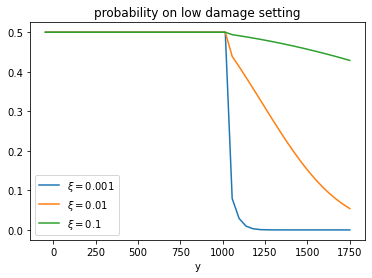

In [204]:
plt.plot(y_grid_small[5:]-250, π_grid_small[0, 25][5:], label=r'$\xi=0.001$')
plt.plot(y_grid_mid[5:]-250, π_grid_mid[0, 25][5:], label=r'$\xi=0.01$')
plt.plot(y_grid[5:]-250, π_grid[0,25][5:], label=r'$\xi=0.1$')
plt.legend()
plt.title('probability on low damage setting')
plt.xlabel('y')
plt.savefig('plot.pdf')

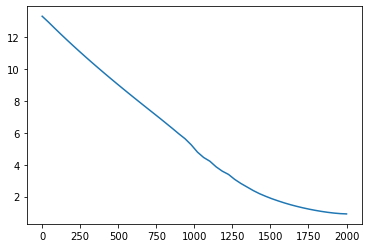

In [162]:
plt.plot(y_grid, e_grid[25])

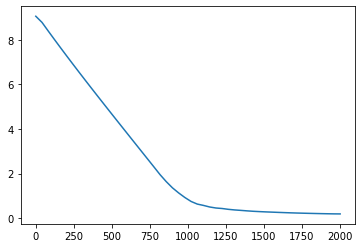

In [156]:
plt.plot(y_grid, e_grid[25])

In [150]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=100):
    ht = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        ht[i] = np.interp(y_start, y_grid, h_grid[z_loc])
        y_start = y_start + e
    return ht


@njit(parallel=True)
def simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=100):
    πt = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        πt[i] = np.interp(y_start, y_grid, π_grid[0, z_loc])
        y_start = y_start + e
    return πt


@njit(parallel=True)
def simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p, λ_bar, y_start=290, z_loc=25, T=100):
    nt = np.zeros(T+1)
    for i in range(T+1):
        e = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + e
        nt[i] = 1./np.exp(λ_1*μ_2*y_start + 0.5*λ_2*(μ_2*y_start)**2 + 0.5*λ_2p*(μ_2*y_start-λ_bar)**2*(μ_2*y_start>λ_bar))
    return nt


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [153]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)
ht = simulate_h(e_grid, y_grid, h_grid, y_start=290, z_loc=25, T=T)
πt = simulate_π(e_grid, y_grid, π_grid, y_start=290, z_loc=25, T=T)
nt_low = simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p[0], λ_bar, y_start=290, z_loc=25, T=100)
nt_high = simulate_damage(e_grid, y_grid, λ_1, λ_2, λ_2p[1], λ_bar, y_start=290, z_loc=25, T=100)

Text(0.5, 0, 'Year')

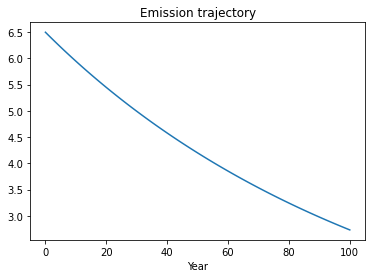

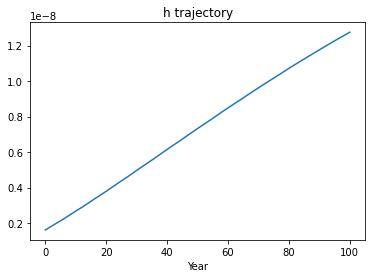

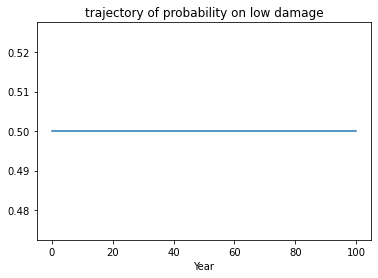

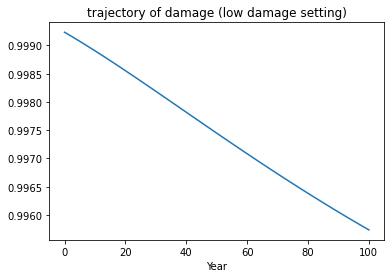

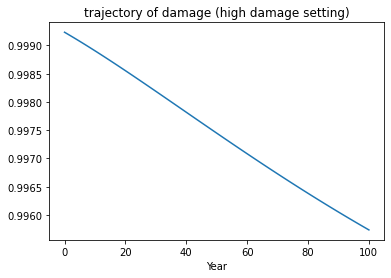

In [154]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')
plt.figure()
plt.title('h trajectory')
plt.plot(ht)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of probability on low damage')
plt.plot(πt)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of damage (low damage setting)')
plt.plot(nt_low)
plt.xlabel('Year')
plt.figure()
plt.title('trajectory of damage (high damage setting)')
plt.plot(nt_high)
plt.xlabel('Year')

In [ ]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

In [ ]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [ ]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

In [ ]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [ ]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [ ]:
(1-δ/(α-ioverk))/ioverk

In [ ]:
-0.0429 + ioverk - κ/2.*ioverk**2

In [ ]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

In [ ]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [ ]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])